# Import

In [143]:
# !pip install torchsummary

In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchsummary import summary
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure save directory exists
save_dir = './comparison_images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load dataset

In [145]:
def prepare_cifar10_dataset(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# Show image after traiining and testing

In [146]:
# Function to denormalize images
def denormalize(tensor):
    return tensor * 0.5 + 0.5

In [147]:
def visualize_single_image(original_image, generated_image, epoch, model_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))

    original_img = original_image.cpu().numpy().transpose((1, 2, 0))
    original_img = denormalize(original_img)
    original_img = np.clip(original_img, 0, 1)

    axes[0].imshow(original_img)
    axes[0].set_title('Original')
    axes[0].axis('off')

    generated_img = generated_image.detach().cpu().numpy().transpose((1, 2, 0))
    generated_img = denormalize(generated_img)
    generated_img = np.clip(generated_img, 0, 1)

    axes[1].imshow(generated_img)
    axes[1].set_title(f'Generated ({model_name}) - Epoch {epoch}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(f'{save_dir}/comparison_epoch_{epoch}_{model_name}.png')
    plt.show()

# Calculate PSNR. SSIM

In [148]:
# Function to calculate PSNR and SSIM
def calculate_metrics(original_images, generated_images):
    original_images = denormalize(original_images).detach().cpu().numpy().transpose((0, 2, 3, 1))
    generated_images = denormalize(generated_images).detach().cpu().numpy().transpose((0, 2, 3, 1))

    psnr_values = []
    ssim_values = []

    for original_img, generated_img in zip(original_images, generated_images):
        psnr_val = psnr(original_img, generated_img, data_range=1.0)
        ssim_val = ssim(original_img, generated_img, data_range=1.0, channel_axis=-1)
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    mean_psnr = np.mean(psnr_values)
    mean_ssim = np.mean(ssim_values)

    return mean_psnr, mean_ssim

# Model design: DDPM and DIP

In [149]:
# DDPM Block
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.Dropout(p=0.2)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise + self.net(x)

# DDPM Model
class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

In [150]:
# Simplified DIP model using nn.Sequential
class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.model(x)
        x = x.view(-1, 3, 32, 32)
        return x

# Training

In [151]:
# Train combined DDPM and DIP model
def train_combined_model_ddpm_dip(ddpm, dip, dataloader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(list(ddpm.parameters()) + list(dip.parameters()), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ddpm.to(device)
    dip.to(device)

    for epoch in range(num_epochs):
        ddpm.train()
        dip.train()
        total_loss = 0.0
        total_psnr = 0.0
        total_ssim = 0.0
        num_batches = len(dataloader)

        for batch_idx, (images, _) in enumerate(dataloader):
            images = images.to(device)

            optimizer.zero_grad()

            # Generate priors using DIP
            initial_priors = dip(images)

            # Generate images using DDPM with priors
            t = torch.randint(0, len(ddpm.blocks), (1,)).item()
            generated_images = ddpm(images + initial_priors, t)

            # Compute loss (MSE loss between generated and real images)
            loss = criterion(generated_images, images)

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_psnr, batch_ssim = calculate_metrics(images, generated_images)
            total_psnr += batch_psnr
            total_ssim += batch_ssim

        # Calculate mean loss, PSNR, and SSIM for the epoch
        mean_loss = total_loss / num_batches
        mean_psnr = total_psnr / num_batches
        mean_ssim = total_ssim / num_batches
        print(f'Epoch [{epoch + 1}/{num_epochs}], Mean Loss: {mean_loss:.4f}, Mean PSNR: {mean_psnr:.2f}, Mean SSIM: {mean_ssim:.4f}')

        # Visualize a single image after each epoch
        visualize_single_image(images[0], generated_images[0], epoch + 1, "DDPM+DIP")
        
        # Step the scheduler
        scheduler.step()

In [152]:
def train_ddpm_only(ddpm, dataloader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ddpm.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ddpm.to(device)

    for epoch in range(num_epochs):
        ddpm.train()
        total_loss = 0.0
        total_psnr = 0.0
        total_ssim = 0.0
        num_batches = len(dataloader)

        for batch_idx, (images, _) in enumerate(dataloader):
            images = images.to(device)

            optimizer.zero_grad()

            # Generate images using DDPM without priors
            t = torch.randint(0, len(ddpm.blocks), (1,)).item()
            generated_images = ddpm(images, t)

            # Compute loss (MSE loss between generated and real images)
            loss = criterion(generated_images, images)

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_psnr, batch_ssim = calculate_metrics(images, generated_images)
            total_psnr += batch_psnr
            total_ssim += batch_ssim

        # Calculate mean loss, PSNR, and SSIM for the epoch
        mean_loss = total_loss / num_batches
        mean_psnr = total_psnr / num_batches
        mean_ssim = total_ssim / num_batches
        print(f'Epoch [{epoch + 1}/{num_epochs}], Mean Loss: {mean_loss:.4f}, Mean PSNR: {mean_psnr:.2f}, Mean SSIM: {mean_ssim:.4f}')

        # Visualize a single image after each epoch
        visualize_single_image(images[0], generated_images[0], epoch + 1, "DDPM Only")
    
        # Step the scheduler
        scheduler.step()

# Testing

In [153]:
def validate_model(ddpm, dip, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ddpm.to(device)
    if dip:
        dip.to(device)
        dip.eval()
    ddpm.eval()

    total_psnr = 0.0
    total_ssim = 0.0
    num_batches = len(dataloader)

    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(dataloader):
            images = images.to(device)

            if dip:
                # Generate priors using DIP
                initial_priors = dip(images)
                # Generate images using DDPM with priors
                t = torch.randint(0, len(ddpm.blocks), (1,)).item()
                generated_images = ddpm(images + initial_priors, t)
            else:
                # Generate images using DDPM without priors
                t = torch.randint(0, len(ddpm.blocks), (1,)).item()
                generated_images = ddpm(images, t)

            # Calculate PSNR and SSIM for this batch
            batch_psnr, batch_ssim = calculate_metrics(images, generated_images)
            total_psnr += batch_psnr
            total_ssim += batch_ssim

    mean_psnr = total_psnr / num_batches
    mean_ssim = total_ssim / num_batches
    print(f'Validation Mean PSNR: {mean_psnr:.2f}, Mean SSIM: {mean_ssim:.4f}')
    return mean_psnr, mean_ssim

# Ablation Studies:  noise levels. denoising schedules. learning_rate. batch_size

In [154]:
def noise_level_experiment(ddpm, dip, train_loader, test_loader, noise_levels):
    results = []
    for noise_level in noise_levels:
        print(f"=========Noise Level: {noise_level}=========")
        # Adjust noise level in DDPM
        ddpm = DDPM(num_blocks=3, channels=3, noise_schedule=np.linspace(noise_level, 0.1, 1000))
        train_combined_model_ddpm_dip(ddpm, dip, train_loader, num_epochs=3, lr=0.0001)
        mean_psnr, mean_ssim = validate_model(ddpm, dip, test_loader)
        results.append((noise_level, mean_psnr, mean_ssim))
    return results

def denoising_steps_experiment(ddpm, dip, train_loader, test_loader, denoising_steps):
    results = []
    for steps in denoising_steps:
        print(f"=========Denoising Steps: {steps}=========")
        # Adjust denoising steps in DDPM
        ddpm = DDPM(num_blocks=3, channels=3, noise_schedule=np.linspace(0.03, 0.1, steps))
        train_combined_model_ddpm_dip(ddpm, dip, train_loader, num_epochs=3, lr=0.0001)
        mean_psnr, mean_ssim = validate_model(ddpm, dip, test_loader)
        results.append((steps, mean_psnr, mean_ssim))
    return results

def learning_rate_experiment(ddpm, dip, train_loader, test_loader, learning_rates):
    results = []
    for lr in learning_rates:
        print(f"=========Learning Rate: {lr}=========")
        train_combined_model_ddpm_dip(ddpm, dip, train_loader, num_epochs=3, lr=lr)
        mean_psnr, mean_ssim = validate_model(ddpm, dip, test_loader)
        results.append((lr, mean_psnr, mean_ssim))
    return results

def batch_size_experiment(dip, ddpm, batch_sizes):
    results = []
    for batch_size in batch_sizes:
        print(f"=========Batch Size: {batch_size}=========")
        train_loader, test_loader = prepare_cifar10_dataset(batch_size)
        # Train DDPM + DIP model
        noise_schedule = np.linspace(0.03, 0.1, 1000)
        ddpm = DDPM(num_blocks=3, channels=3, noise_schedule=noise_schedule)
        print("=========I am training DDPM+DIP=========")
        train_combined_model_ddpm_dip(ddpm, dip, train_loader, num_epochs=3, lr=0.001)
        # Validate model on test data
        print("=========I am testing DDPM+DIP=========")
        mean_psnr_ddpm_dip, mean_ssim_ddpm_dip = validate_model(ddpm, dip, test_loader)
        results.append((batch_size, mean_psnr_ddpm_dip, mean_ssim_ddpm_dip))
    return results


# Main

Files already downloaded and verified
Files already downloaded and verified
=========I am training DDPM+DIP=========
Epoch [1/5], Mean Loss: 0.0294, Mean PSNR: 23.43, Mean SSIM: 0.8280


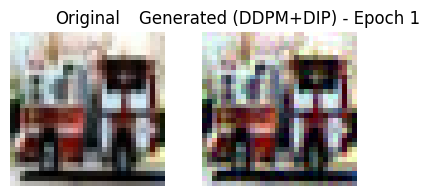

Epoch [2/5], Mean Loss: 0.0064, Mean PSNR: 28.10, Mean SSIM: 0.9085


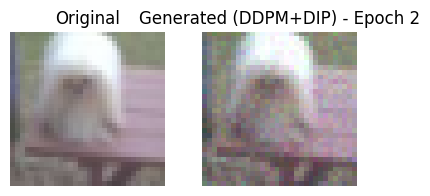

Epoch [3/5], Mean Loss: 0.0047, Mean PSNR: 29.41, Mean SSIM: 0.9252


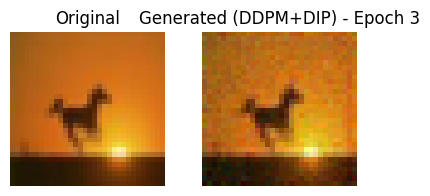

Epoch [4/5], Mean Loss: 0.0041, Mean PSNR: 30.05, Mean SSIM: 0.9323


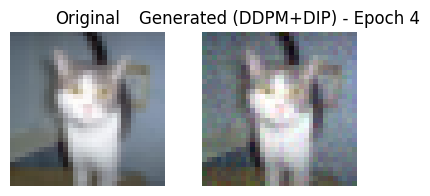

Epoch [5/5], Mean Loss: 0.0037, Mean PSNR: 30.45, Mean SSIM: 0.9364


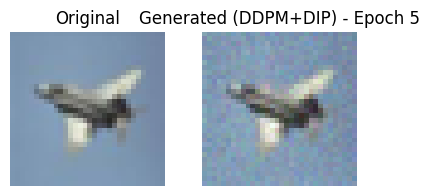

=========I am testing DDPM+DIP=========
Validation Mean PSNR: 31.07, Mean SSIM: 0.9417
=========I am training DDPM only=========
Epoch [1/5], Mean Loss: 0.0027, Mean PSNR: 31.74, Mean SSIM: 0.9458


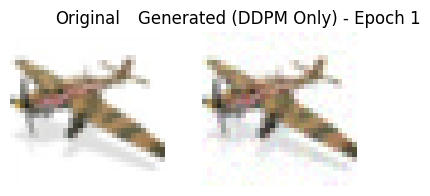

Epoch [2/5], Mean Loss: 0.0022, Mean PSNR: 32.57, Mean SSIM: 0.9528


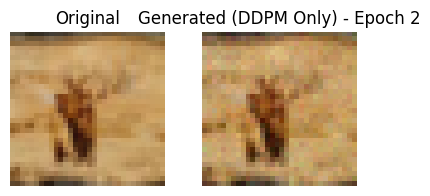

Epoch [3/5], Mean Loss: 0.0021, Mean PSNR: 32.77, Mean SSIM: 0.9545


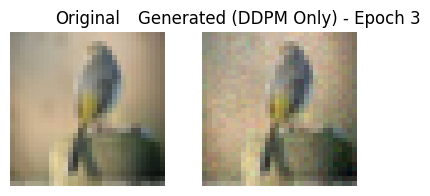

Epoch [4/5], Mean Loss: 0.0021, Mean PSNR: 32.84, Mean SSIM: 0.9553


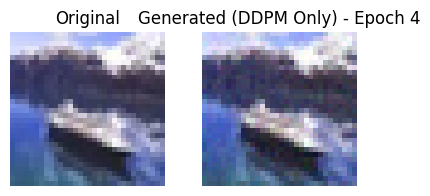

Epoch [5/5], Mean Loss: 0.0021, Mean PSNR: 32.89, Mean SSIM: 0.9558


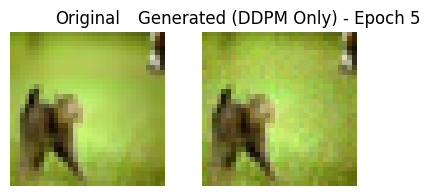

=========I am testing DDPM only=========
Validation Mean PSNR: 33.17, Mean SSIM: 0.9580
=========Noise Level: 0.01=========
Epoch [1/3], Mean Loss: 0.0179, Mean PSNR: 25.44, Mean SSIM: 0.8850


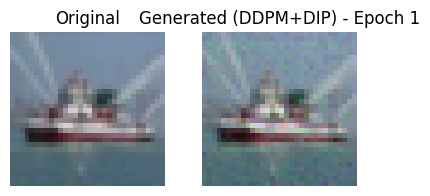

Epoch [2/3], Mean Loss: 0.0027, Mean PSNR: 32.18, Mean SSIM: 0.9662


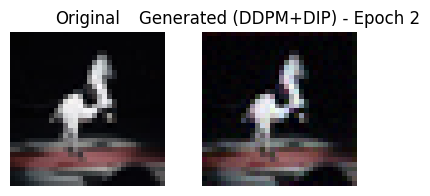

Epoch [3/3], Mean Loss: 0.0016, Mean PSNR: 34.37, Mean SSIM: 0.9797


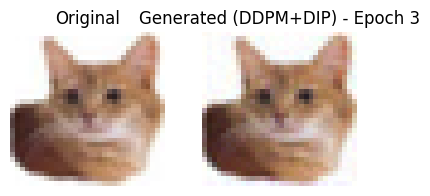

Validation Mean PSNR: 36.26, Mean SSIM: 0.9865
=========Noise Level: 0.05=========
Epoch [1/3], Mean Loss: 0.0205, Mean PSNR: 23.32, Mean SSIM: 0.7900


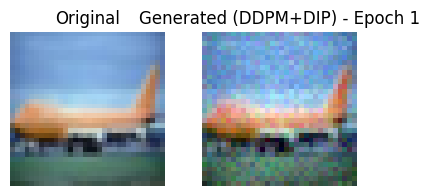

Epoch [2/3], Mean Loss: 0.0097, Mean PSNR: 26.21, Mean SSIM: 0.8603


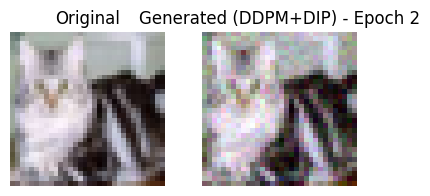

Epoch [3/3], Mean Loss: 0.0081, Mean PSNR: 26.99, Mean SSIM: 0.8750


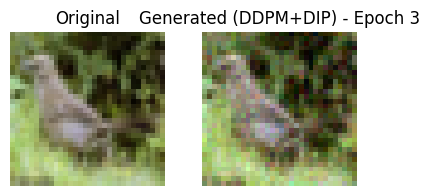

Validation Mean PSNR: 27.39, Mean SSIM: 0.8816
=========Noise Level: 0.1=========
Epoch [1/3], Mean Loss: 0.0524, Mean PSNR: 19.13, Mean SSIM: 0.6588


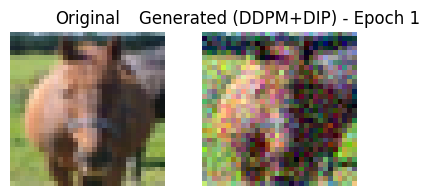

Epoch [2/3], Mean Loss: 0.0323, Mean PSNR: 20.95, Mean SSIM: 0.7025


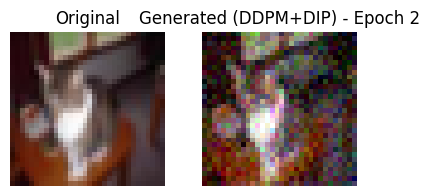

Epoch [3/3], Mean Loss: 0.0276, Mean PSNR: 21.62, Mean SSIM: 0.7235


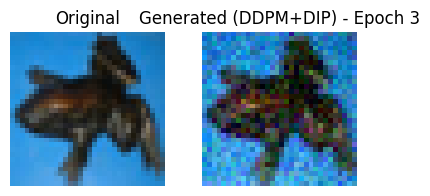

Validation Mean PSNR: 22.02, Mean SSIM: 0.7371
Noise Level Experiment Results: [(0.01, 36.264279711114675, 0.9865010433895572), (0.05, 27.385407429371668, 0.8815636585472496), (0.1, 22.022560449740656, 0.7370819794903894)]
=========Denoising Steps: 5=========
Epoch [1/3], Mean Loss: 0.0203, Mean PSNR: 23.83, Mean SSIM: 0.8159


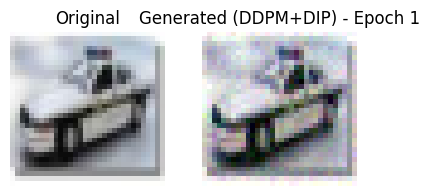

Epoch [2/3], Mean Loss: 0.0103, Mean PSNR: 26.34, Mean SSIM: 0.8633


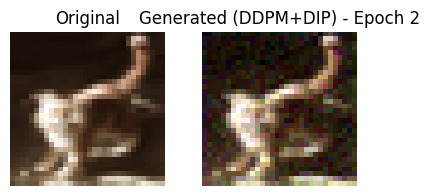

Epoch [3/3], Mean Loss: 0.0089, Mean PSNR: 27.06, Mean SSIM: 0.8741


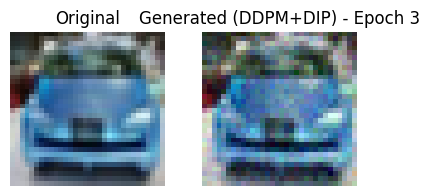

Validation Mean PSNR: 27.52, Mean SSIM: 0.8797
=========Denoising Steps: 10=========
Epoch [1/3], Mean Loss: 0.0430, Mean PSNR: 20.86, Mean SSIM: 0.7851


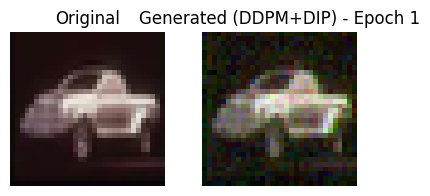

Epoch [2/3], Mean Loss: 0.0096, Mean PSNR: 26.36, Mean SSIM: 0.8745


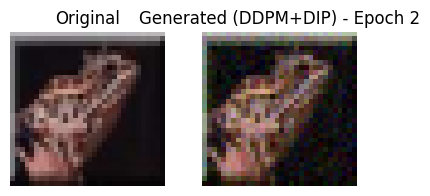

Epoch [3/3], Mean Loss: 0.0069, Mean PSNR: 27.75, Mean SSIM: 0.8933


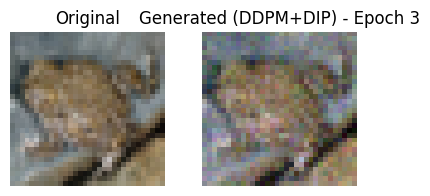

Validation Mean PSNR: 28.92, Mean SSIM: 0.9120
=========Denoising Steps: 20=========
Epoch [1/3], Mean Loss: 0.0152, Mean PSNR: 24.95, Mean SSIM: 0.8464


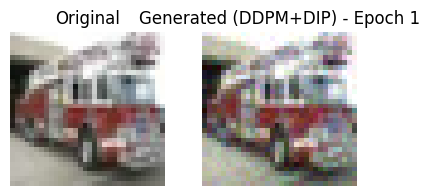

Epoch [2/3], Mean Loss: 0.0057, Mean PSNR: 28.59, Mean SSIM: 0.9119


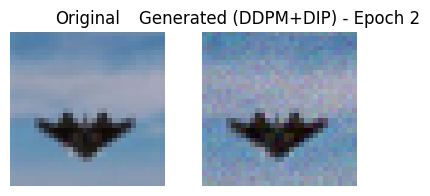

Epoch [3/3], Mean Loss: 0.0045, Mean PSNR: 29.57, Mean SSIM: 0.9238


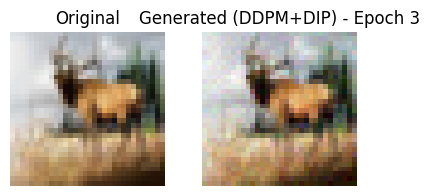

Validation Mean PSNR: 30.12, Mean SSIM: 0.9289
Denoising Steps Experiment Results: [(5, 27.520944448736877, 0.8797296862693349), (10, 28.915344831497414, 0.9119954363555666), (20, 30.116753341364934, 0.9289215529800221)]
=========Learning Rate: 0.0001=========
Epoch [1/3], Mean Loss: 0.0023, Mean PSNR: 32.64, Mean SSIM: 0.9559


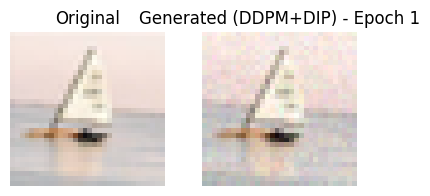

Epoch [2/3], Mean Loss: 0.0022, Mean PSNR: 32.68, Mean SSIM: 0.9563


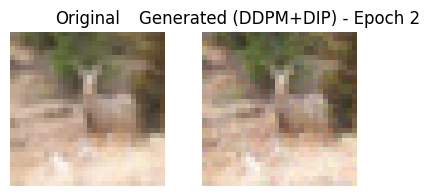

Epoch [3/3], Mean Loss: 0.0022, Mean PSNR: 32.71, Mean SSIM: 0.9566


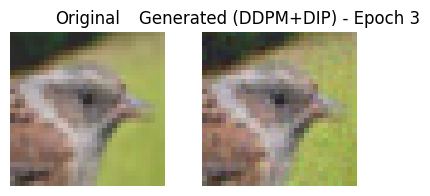

Validation Mean PSNR: 33.03, Mean SSIM: 0.9591
=========Learning Rate: 1e-05=========
Epoch [1/3], Mean Loss: 0.0022, Mean PSNR: 32.72, Mean SSIM: 0.9567


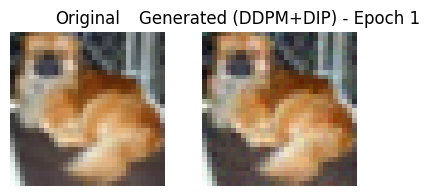

Epoch [2/3], Mean Loss: 0.0022, Mean PSNR: 32.72, Mean SSIM: 0.9567


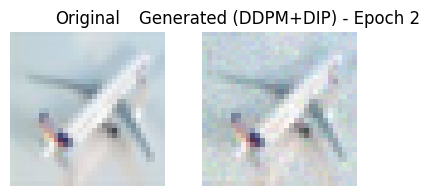

Epoch [3/3], Mean Loss: 0.0022, Mean PSNR: 32.73, Mean SSIM: 0.9568


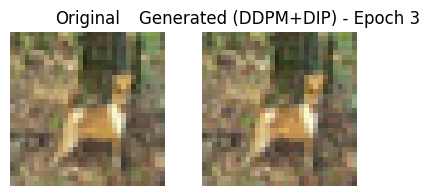

Validation Mean PSNR: 33.02, Mean SSIM: 0.9592
Learning Rate Experiment Results: [(0.0001, 33.03078034479308, 0.9591380760168574), (1e-05, 33.02404811010825, 0.9592050803694755)]
=========Batch Size: 32=========
Files already downloaded and verified
Files already downloaded and verified
=========I am training DDPM+DIP=========
Epoch [1/3], Mean Loss: 0.0035, Mean PSNR: 31.30, Mean SSIM: 0.9409


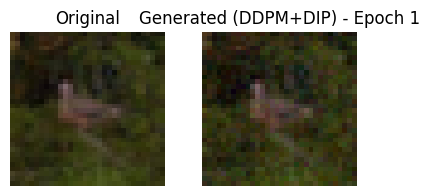

Epoch [2/3], Mean Loss: 0.0024, Mean PSNR: 32.38, Mean SSIM: 0.9530


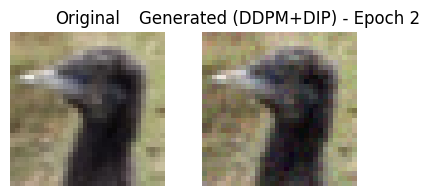

Epoch [3/3], Mean Loss: 0.0023, Mean PSNR: 32.52, Mean SSIM: 0.9545


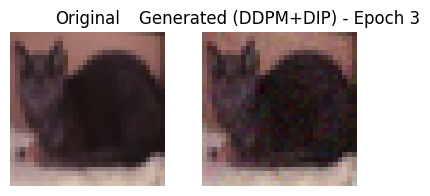

=========I am testing DDPM+DIP=========
Validation Mean PSNR: 32.75, Mean SSIM: 0.9568
=========Batch Size: 64=========
Files already downloaded and verified
Files already downloaded and verified
=========I am training DDPM+DIP=========
Epoch [1/3], Mean Loss: 0.0077, Mean PSNR: 28.85, Mean SSIM: 0.9092


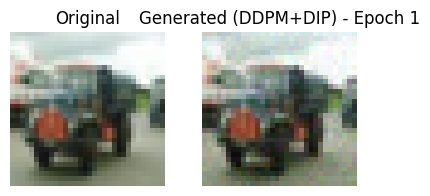

Epoch [2/3], Mean Loss: 0.0028, Mean PSNR: 31.67, Mean SSIM: 0.9467


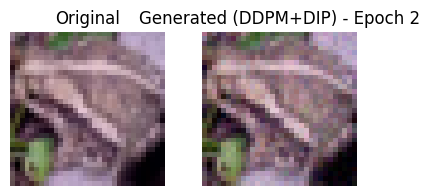

Epoch [3/3], Mean Loss: 0.0026, Mean PSNR: 32.03, Mean SSIM: 0.9500


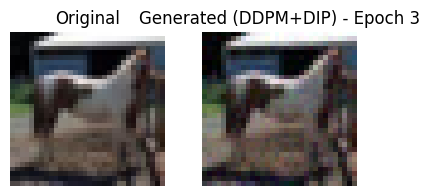

=========I am testing DDPM+DIP=========
Validation Mean PSNR: 32.27, Mean SSIM: 0.9519
Batch Size Experiment Results: [(32, 32.75372899736111, 0.9567597546516516), (64, 32.2707672291599, 0.9518791805407044)]


In [155]:
if __name__ == '__main__':
    # Noise schedule
    noise_schedule = np.linspace(0.03, 0.1, 1000)

    # Initialize DDPM and DIP models
    ddpm = DDPM(num_blocks=3, channels=3, noise_schedule=noise_schedule)
    dip = DIP()

    # Prepare CIFAR-10 dataset
    batch_size = 64
    train_loader, test_loader = prepare_cifar10_dataset(batch_size)

    # Train DDPM + DIP model
    print("=========I am training DDPM+DIP=========")
    train_combined_model_ddpm_dip(ddpm, dip, train_loader, num_epochs=5, lr=0.0001)

    # Validate model on test data
    print("=========I am testing DDPM+DIP=========")
    validate_model(ddpm, dip, test_loader)

    # Train DDPM only model
    print("=========I am training DDPM only=========")
    train_ddpm_only(ddpm, train_loader, num_epochs=5, lr=0.0001)

    # Validate DDPM only model on test data
    print("=========I am testing DDPM only=========")
    validate_model(ddpm, None, test_loader)

    # =====================================================================

    # Noise level experiment
    noise_levels = [0.01, 0.05, 0.1]
    noise_results = noise_level_experiment(ddpm, dip, train_loader, test_loader, noise_levels)
    print("Noise Level Experiment Results:", noise_results)

    # Denoising steps experiment
    denoising_steps = [5, 10, 20]
    steps_results = denoising_steps_experiment(ddpm, dip, train_loader, test_loader, denoising_steps)
    print("Denoising Steps Experiment Results:", steps_results)

    # Learning rate experiment
    learning_rates = [0.0001, 0.00001]
    lr_results = learning_rate_experiment(ddpm, dip, train_loader, test_loader, learning_rates)
    print("Learning Rate Experiment Results:", lr_results)

     # Batch size experiment
    batch_sizes = [32, 64]
    batch_results = batch_size_experiment(dip, ddpm, batch_sizes)
    print("Batch Size Experiment Results:", batch_results)